In [1]:
ModelToLoad = 6

In [ ]:
### Memory commands

print(torch.cuda.memory_allocated()/1024**3)
print(torch.cuda.memory_cached()/1024**3)
torch.cuda.empty_cache()

# x = torch.randn(1024**3, device='cuda')
# device='cuda:0'
# x = x.cuda()
# del y
# print(x.dtype)
# print('OnGPUMemory:', x.element_size()*x.nelement()/1024**3, 'GB')

# torch.cuda.memory_allocated()
# torch.cuda.max_memory_allocated()/1024**3
# torch.cuda.memory_reserved()
# torch.cuda.max_memory_reserved()/1024**3
# torch.cuda.empty_cache()
# torch.cuda.memory_stats()
# torch.cuda.memory_snapshot()

# torch.cuda.get_device_properties(device)
# torch.cuda.memory_usage()
# torch.cuda.list_gpu_processes() ####################################################
# print(torch.cuda.memory_summary()) #######################################

In [8]:
# Imports, class definitions
# print("Importing ...")

import torch
import torch.nn as nn
import torch.optim as optim
from   torch.utils.data import DataLoader
import torchvision.transforms as transforms # Using TorchIO may help in 3D augmentation *
import nibabel as nib
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# Define your model architecture here
# print("Defining Classes ...")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels , out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module): #
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2] # NCXYZ
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2,
                                    diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module): ### Add dropout!
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

# Define a custom transform class for applying the same random crop
class RandomCrop3D: ###
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        inputs, targets = sample

        # Get the input size
        input_size = inputs.shape[2:] ###

        # Calculate the starting index for the crop
        start_indexes = [random.randint(0, input_size[i] - self.output_size[i]) for i in range(3)]

        # Perform the crop on both inputs and targets
        inputs  = inputs [:,:, start_indexes[0]:start_indexes[0] + self.output_size[0], 
                               start_indexes[1]:start_indexes[1] + self.output_size[1],
                               start_indexes[2]:start_indexes[2] + self.output_size[2]]

        targets = targets[:,:, start_indexes[0]:start_indexes[0] + self.output_size[0], 
                               start_indexes[1]:start_indexes[1] + self.output_size[1],
                               start_indexes[2]:start_indexes[2] + self.output_size[2]]

        return inputs, targets

# Define the output size for random cropping
output_size = (128, 128, 128)

# Define the transforms
transform = transforms.Compose([
    RandomCrop3D(output_size),              # Custom random crop
    # transforms.RandomVerticalFlip(),        # Random vertical flipping
    # transforms.RandomHorizontalFlip()        # Random horizontal flipping
])

# Define your dataset class for loading CT images and masks

class CTImageDataset(torch.utils.data.Dataset): ###
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths

    def __getitem__(self, index):
        image = nib.load(self.image_paths[index]).get_fdata()
        mask  = nib.load(self.mask_paths [index]).get_fdata()
        image = torch.from_numpy(image).unsqueeze(0).float() ### 1-Channel?!
        mask  = torch.from_numpy(mask ).unsqueeze(0).long() ### Changed!
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [3]:
# Training function definition

def train(model, train_loader, criterion, optimizer, device): ###
    model.train() ###
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        # print(f"Batch {batch_idx+1} Started")

        images = images.to(device)
        masks  = masks .to(device)

        # Apply transforms to the inputs and targets
        images, masks = transform((images, masks))

        optimizer.zero_grad()

        # Forward pass
        # print("Passing through Model ...")
        outputs = model(images)

        # Compute loss
        # print("CrossEnthropy() ...")
        loss = criterion(outputs, torch.squeeze(masks, dim=1)) #####################################

        # Backward pass and optimization
        # print("Backward ...")
        loss.backward()
        # print("Step ...")
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

In [6]:
# Training parameters: device, epochs, lr, ..
# print("Setting Parameters & Instanciating ...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ####1
epochs = 10
batch_size = 1 #4 ###
learning_rate = 0.001 #0.0001 ###

# Create your model instance

model = UNet3D(in_channels=1, out_channels=3)
model = model.to(device)
# GMem+=0.4GB > 3.1GB

In [5]:
### Count the number of trainable parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_parameters}")
# Number of trainable parameters: 40158723

# Model size
print("Model size assuming float32bit weights:", 40158723*32/8/1024**2, "MB")

# print(model)

Number of trainable parameters: 40158723
Model size assuming float32bit weights: 153.1933708190918 MB


In [12]:
### Parameters table
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Mod name", "Parameters Listed"])
    t_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        t_params+=param
    print(table)
    print(f"Sum of trained paramters: {t_params}")
    return t_params

count_parameters(model)

+-------------------------------------------+-------------------+
|                  Mod name                 | Parameters Listed |
+-------------------------------------------+-------------------+
|          inc.double_conv.0.weight         |        1728       |
|           inc.double_conv.0.bias          |         64        |
|          inc.double_conv.1.weight         |         64        |
|           inc.double_conv.1.bias          |         64        |
|          inc.double_conv.3.weight         |       110592      |
|           inc.double_conv.3.bias          |         64        |
|          inc.double_conv.4.weight         |         64        |
|           inc.double_conv.4.bias          |         64        |
| down1.maxpool_conv.1.double_conv.0.weight |       221184      |
|  down1.maxpool_conv.1.double_conv.0.bias  |        128        |
| down1.maxpool_conv.1.double_conv.1.weight |        128        |
|  down1.maxpool_conv.1.double_conv.1.bias  |        128        |
| down1.ma

40158723

In [7]:
# Load specific model, image paths, criterion/optimizer

model.load_state_dict(torch.load("M-Model-"+f'{ModelToLoad:02.0f}'+".pth")) ########################## m1
# GMem+=0.6GB > 3.7GB

# Create your dataset and data loader instances

image_paths_train = ["Data\SPIROMCS-Case36-Vx3.nii.gz"        , "Data\SPIROMCS-Case43-Vx3.nii.gz"]
mask_paths_train  = ["Data\SPIROMCS-Case36-012Labelmap.nii.gz", "Data\SPIROMCS-Case43-012Labelmap.nii.gz"]
train_dataset = CTImageDataset(image_paths_train, mask_paths_train) ### Cases 43&36 ### M:1 A:2 V:3 > 012!
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) ### Mask: B=1?C=1?XYZ? #shuffle=True

# Define your loss function and optimizer

weight = torch.tensor([1,10,10], dtype=torch.float, device=device)
criterion = nn.CrossEntropyLoss(weight=weight) ####2 ignore_index (int, optional) *** #### Using max of all N losses?!!!!
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ###

In [ ]:
### ToDo: Get label distribution for calss weights
# Here!
# np.array([1,10,10])/21

In [13]:
# Start the training loop, create losses list, save the model
print("Start Training ...")

losscurve = []
# GMem=3GB

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device) ########
    losscurve.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

# Save the trained model
# "A"+str(3)  # f'{3:02.0f}'
torch.save(model.state_dict(), "M-Model-"+f'{ModelToLoad+1:02.0f}'+".pth") ######################## m2
# GMem=18.7GB-19.4GB

Start Training ...
Epoch 1/5, Train Loss: 0.3785
Epoch 2/5, Train Loss: 0.3697
Epoch 3/5, Train Loss: 0.4438
Epoch 4/5, Train Loss: 0.2521
Epoch 5/5, Train Loss: 0.2833


In [14]:
# Appends loss values to file, uses custom label, updates LastIteration # LastIteration = 165
# LastIteration = 165

# Open the file in append mode
with open('D-Lossvalues.b', 'a') as file:
    # Write each number on a new line
    for indx, num in enumerate(losscurve):
        file.write(f'{LastIteration+indx+1:07.0f}, ' + f'{num:015.13f}, ' + 
            'UsingModel-05|LR=0.001|x5' + '\n')

LastIteration = LastIteration + indx + 1
print('LastIteration: ' + str(LastIteration))

LastIteration: 170


In [95]:
# Read: losses and labels from file; Create: train_losses, ulabels, ulabindices

train_losses = [] #>> # List to store the second values
labels = [] #>

with open('D-Lossvalues.b', 'r') as file:
    for line in file:
        parts = line.strip().split(", ")        
        train_loss = parts[1]
        label = parts[2]

        train_losses.append(float(train_loss))
        labels.append(label)

# Processing the labels above: Getting the unique labels:

currentlabel = []
ulabindices = [] #>>
ulabels = [] #>>

for indx,lab in enumerate(labels):
    if lab != currentlabel:
        ulabindices.append(indx)
        ulabels.append(lab)
        currentlabel = lab

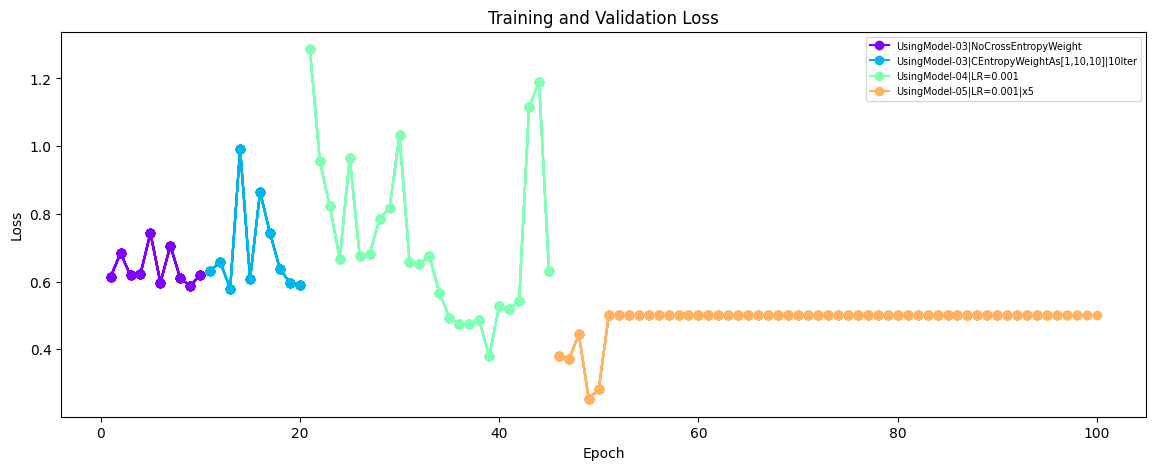

In [100]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
colormap = plt.cm.get_cmap('rainbow')

# train_losses = [-1,2,4]
valid_losses = [2,5,-1]

def update_plot(epoch, train_loss, valid_loss):

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    clear_output(wait=True)

    xx = range(1, len(train_losses)+1)
    yy = train_losses
    labinds = ulabindices + [len(train_losses)]

    for i, label in enumerate(ulabels):
        ax.plot(xx[labinds[i]:labinds[i+1]], yy[labinds[i]:labinds[i+1]], 'o-', label=label, color=colormap(i/len(ulabels)))
        # ax.plot(range(1, len(valid_losses)+1), valid_losses, 'ro-', label='Valid')

    # Adjust the plot limits if needed
    ax.relim()
    ax.autoscale_view()
    if epoch == 0: ax.legend(fontsize='x-small')

    display(fig)
    # plt.pause(0.001)

for epoch in range(10):
    # Training loop
    train_loss = 0.5 # -epoch+1
    
    # Validation loop
    valid_loss = -epoch+2

    # Update the plot
    update_plot(epoch, train_loss, valid_loss)   
    time.sleep(1) # Sleep for 3 seconds
    
# Close the plot after the loop finishes

plt.close(fig)

In [49]:
# Infer step
# Load the trained model
# model.load_state_dict(torch.load("model-03.pth"))
model.eval()

# Load and preprocess the input image
image = nib.load("Data\SPIROMCS-Case36-Vx3.nii.gz").get_fdata()
mask  = nib.load("Data\SPIROMCS-Case36-012Labelmap.nii.gz").get_fdata()

image = torch.from_numpy(image).unsqueeze(0).float() ### Channels=1 !
mask  = torch.from_numpy(mask ).unsqueeze(0).long()  ### Changed!

input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
mask_tensor  = mask .unsqueeze(0).to(device)  # Add batch dimension ############## to(device) after tramsform!

input_tensor, mask_tensor = transform((input_tensor, mask_tensor))

# Perform inference
with torch.no_grad():
    output_tensor = model(input_tensor)

# Post-process the output tensor
output_tensor = torch.argmax(output_tensor, dim=1)  # Convert to class labels (assuming CrossEntropyLoss was used)

In [50]:
# Save infer artifacts x3 to disk

output_array = output_tensor.squeeze(0).cpu().numpy().astype('int16')
img = nib.Nifti1Image(output_array, np.eye(4))
nib.save(img, "./Data/36-OutputArray.nii.gz")

mask_array = mask_tensor.squeeze(dim=(0,1)).cpu().numpy().astype('int16')
img = nib.Nifti1Image(mask_array, np.eye(4))
nib.save(img, "./Data/36-MaskArray.nii.gz")

input_array = input_tensor.squeeze(dim=(0,1)).cpu().numpy().astype('int16')
img = nib.Nifti1Image(input_array, np.eye(4))
nib.save(img, "./Data/36-CroppedImage.nii.gz")

In [99]:
# Memory Investigation

x = torch.randn(1024**3, device='cuda')

# y = x+1
# del y
# print(x.dtype)
# print(1024**3*32/8/1024**3, 'GB')

# print(x.element_size()) # 4 Bytes
# print(x.nelement()) # 1024**2
# print('OnGPUMemory:', x.element_size()*x.nelement()/1024**3, 'GB')

print(torch.cuda.memory_allocated()/1024**3)
print(torch.cuda.memory_cached()/1024**3)
torch.cuda.empty_cache()

# torch.cuda.memory_allocated()
# torch.cuda.max_memory_allocated()/1024**3
# torch.cuda.memory_reserved()
# torch.cuda.max_memory_reserved()/1024**3
# torch.cuda.empty_cache()
# torch.cuda.memory_stats()
# torch.cuda.memory_snapshot()

# torch.cuda.get_device_properties(device)
# torch.cuda.memory_usage()
# torch.cuda.list_gpu_processes() ####################################################
# print(torch.cuda.memory_summary()) #######################################

In [ ]:
# Ideas/Notes:
# Normalization ****
# Dropout
# Several threads and gpus

# nn.CrossEntropyLoss(): label_smoothing=0.0?!!

# np.prod(input_tensor.size())/8*32 =
# print(input_tensor.storage().nbytes())

# import sys
# !{sys.executable} -m pip install scipy

# python -c "import torch; print(torch.cuda.is_available())"